In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [22]:
## data

df = pd.read_csv('data.csv')
# df.info()

df['diagnosis'].unique() # M = malignant, B = benign

def func1(x):
    if 'M' in x:
        return 1
    else:
        return 0

df['판정'] = df['diagnosis'].apply(func1)
# df.head()

# 불필요한 columns drop 합니다.
total = df.drop(columns=['id', 'diagnosis', 'Unnamed: 32'])
# total.head()

In [23]:
## train

X = total.drop(['판정'], axis=1)
y = total['판정']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)



In [38]:
## model 
## voting
logistic = LogisticRegression(solver='liblinear', 
                              penalty='l2', # 영문 l + 2입니다.
                              C=0.001,
                              random_state=1)

tree = DecisionTreeClassifier(max_depth=1,
                             criterion='entropy',
                             random_state=1)

knn = KNeighborsClassifier(n_neighbors=1,
                          p=2,
                          metric='minkowski')

voting_estimators = [('logistic', logistic), ('tree', tree),('knn', knn)]
voting = VotingClassifier(estimators=voting_estimators, voting='soft')
clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'Majority voting']
all_clf = [logistic, tree, knn, voting]


In [40]:
## test
# AUC test
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
         % (scores.mean(), scores.std(), label))

ROC AUC: 0.960 (+/- 0.027) [Logistic regression]
ROC AUC: 0.905 (+/- 0.049) [Decision tree]
ROC AUC: 0.895 (+/- 0.056) [KNN]
ROC AUC: 0.982 (+/- 0.017) [Majority voting]


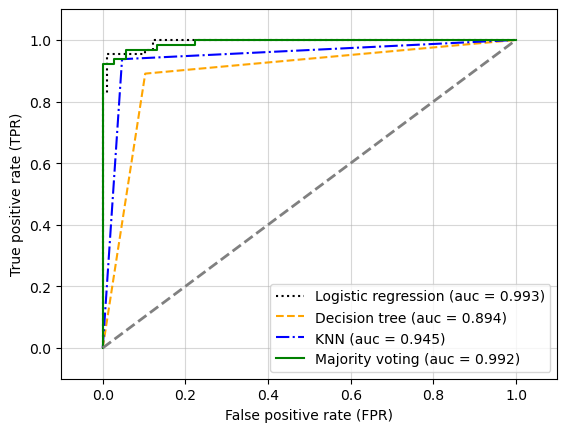

In [41]:
# ROC 곡선 그래프
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.3f)' % (label, roc_auc))
    

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
        linestyle='--',
        color='gray',
        linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

In [42]:
## optimization

voting.get_params() # get_params()으로 사용 가능한 파라미터를 확인할 수 있습니다.

params = {'logistic__C' : [0.001, 0.1, 100.0],
         'tree__max_depth' : [1, 2, 3, 4, 5],
         'knn__n_neighbors' : [1, 2, 3, 4, 5]}
grid = GridSearchCV(estimator=voting,
                   param_grid=params,
                   cv=10,
                   scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.3f %r"
         % (grid.cv_results_['mean_test_score'][r],
           grid.cv_results_['std_test_score'][r] / 2.0,
            grid.cv_results_['params'][r]))
    


In [47]:
print('최적의 파라미터: %s' % grid.best_params_)
print('AUC: %.3f' % grid.best_score_)

최적의 파라미터: {'knn__n_neighbors': 2, 'logistic__C': 100.0, 'tree__max_depth': 3}
AUC: 0.993
